Collaborative filtering using article embeddings
=============
<span style="color: lightsteelblue;">Resulting embeddings are used in article recommendation task.</span>

The goal of this notebook is to train a embedding space over articles from Russian online newspaper.

### Import dependencies

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from pathlib import Path
import pickle
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from IPython.display import clear_output
import matplotlib.pyplot as plt

import itertools
import pandas as pd

### Read data

In [2]:
def read_data(folder):
  data = collections.defaultdict(set)
  num_lines = 0
  num_errors = 0
  data_files = os.listdir(folder)
  for data_file in data_files:
    with open(os.path.join(folder, data_file)) as f:
      for line in f:
        # logs are in the following format:
        # "/article_url 000000000114ssdfrfrf34f4r34"
        data_per_visit = line.rstrip().split(' ')

        if len(data_per_visit) > 1:
          num_lines += 1
          data[data_per_visit[1]].add(data_per_visit[0])
        else: num_errors += 1

  print(f"Successes: {num_lines}")
  print(f"Failures: {num_errors}")
  return data, num_lines

# We want to group all articles by user_ids
# user_id => [articles_ids]
articles_by_users, num_visits = read_data('./logs/clean')

Successes: 13048443
Failures: 629


### Build features (tokenize articles)

Gross total visited 37080 articles by a total of 5406671 unique users in 13048443 visits.
Take only users visiting from 3 to 15 articles.
Net total visited 9246 articles by a total of 369635 unique users.


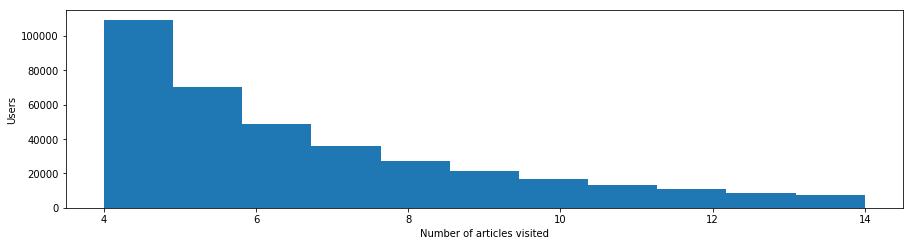

,count
count,369635.000000
mean,6.498283
std,2.674245
min,4.000000
25%,4.000000
50%,6.000000
75%,8.000000
max,14.000000


In [3]:
MIN_NUM_USER_VISITS = 3
MAX_NUM_USER_VISITS = 15

try: all_articles
except NameError:
  all_articles = set(article for user_articles in articles_by_users.values() for article in user_articles)
  array = np.array([[article, user] for user in articles_by_users for article in articles_by_users[user]])
  articles = pd.DataFrame(array, columns = ('url', 'user_id'))
  num_articles = len(all_articles)

print(f"Gross total visited {num_articles} articles by a total of {len(articles_by_users)} unique users in {num_visits} visits.")

visits_by_users = [[len(articles_by_users[user]), user] for user in articles_by_users if MAX_NUM_USER_VISITS > len(articles_by_users[user]) > MIN_NUM_USER_VISITS]
visits = pd.DataFrame(np.array(visits_by_users)[:, 0].astype(int), columns = ['count'])

# net_articles = {article for _, user in visits_by_users for article in articles_by_users[user]}

dictionary = {}
for _, user in visits_by_users:
  for url in (url for url in articles_by_users[user] if url not in dictionary):
    dictionary[url] = len(dictionary)

reverse_dictionary = { id: url for url, id in dictionary.items() }

print(f"Take only users visiting from {MIN_NUM_USER_VISITS} to {MAX_NUM_USER_VISITS} articles.")
print(f"Net total visited {len(dictionary)} articles by a total of {len(visits_by_users)} unique users.")

# visualization
plt.figure().set_size_inches(15, 8)

plt.subplot(211)
plt.xlabel('Number of articles visited')
plt.ylabel('Users')
plt.hist(visits['count'], bins = MAX_NUM_USER_VISITS - MIN_NUM_USER_VISITS - 1)
plt.show()

visits.describe()

In [8]:
# persistently shuffling
dataset_path = "./storage/dataset"

if Path(dataset_path).is_file():
  file_size = os.path.getsize(dataset_path)
  print(f"Loading data from stored file ({file_size} bytes)...")
  with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)
  print('Done')
else:
  print('Shuffling data for the first time ...')
  # shuffled_index = np.random.permutation()
  dataset = [(user, {dictionary[url] for url in articles_by_users[user]}) for _, user in visits_by_users]
  np.random.shuffle(dataset)
  print('Saving data on disk for further access...')
  with open(dataset_path, 'wb') as fp: pickle.dump(dataset, fp)
  file_size = os.path.getsize(dataset_path)
  print(f"Done. It took {file_size} bytes on the disk.")

train_size = int(len(dataset) * 0.8)
train_data = dataset[:train_size]
test_data  = dataset[train_size:]

print(f"Train dataset size: {len(train_data)}")
print(f"Test dataset size: {len(test_data)}\n")

print([[reverse_dictionary[id] for id in ids] for _, ids in train_data[:3]])

Shuffling data for the first time ...
Saving data on disk for further access...
Done. It took 31438689 bytes on the disk.
Train dataset size: 295708
Test dataset size: 73927

[['/articles/2017/11/21/manson', '/articles/2017/12/28/sportvideo_2017', '/articles/2017/12/07/skolko_stoit', '/articles/2017/11/27/selo', '/articles/2017/12/20/v4k', '/articles/2017/11/21/weinsteingame', '/articles/2017/11/20/ww3', '/articles/2018/01/16/ukraine', '/articles/2017/11/24/chernobyl', '/articles/2018/01/15/ronaldo', '/articles/2017/12/12/footbal_doping'], ['/articles/2017/12/05/russiaolympics', '/articles/2017/12/07/amazonki', '/articles/2017/12/08/police', '/articles/2017/12/20/v4k'], ['/articles/2017/12/26/mamun', '/articles/2017/12/26/happy_new_stalin', '/articles/2017/12/26/rusfond37', '/articles/2017/12/26/thailand', '/articles/2017/12/26/frenchcomedy', '/articles/2017/12/26/naishuller']]


### Defining batch

In [9]:
def batches(num_features = 6, num_labels = 3):
  data = train_data

  for user, articles in data:
    if len(articles) < num_features + num_labels: continue
    user_data = np.array(list(articles))
    np.random.shuffle(user_data)

    user_x = user_data[:num_features]
    user_labels = user_data[-num_labels:]

#     for x in itertools.combinations(user_x, num_labels * 2):
    yield user_x, user_labels

def batch_generator(batch_size, num_features, num_labels):
  generator = batches(num_features, num_labels)

  while True:
    x_batch = []
    labels_batch = []

    for i in range(batch_size):
      try:
        next_x, next_label = generator.__next__()
      except StopIteration:
        generator = batches(num_features, num_labels)
        next_x, next_label = generator.__next__()
      x_batch.append(next_x)
      labels_batch.append(next_label)

    yield x_batch, labels_batch

batch = batch_generator(8, 6, 3)

sample_batch_data, sample_batch_labels = batch.__next__()
print(sample_batch_data)
print(sample_batch_labels)
print(np.array(sample_batch_data).shape)
print(np.array(sample_batch_labels).shape)

print(reverse_dictionary[1000])

[array([482, 374,  73, 271, 209,  87]), array([ 16,  51,  52, 122, 369,  64]), array([125, 312,   0,  20, 136, 268]), array([  59,    5, 2807, 1759,  115,   95]), array([111,  56, 194, 333, 239, 100]), array([237, 178, 384,  48, 112, 432]), array([136, 205, 247,  44, 766, 576]), array([219,  24,  50, 223,  39, 214])]
[array([ 21,   0, 229]), array([ 27, 160,   5]), array([214,  27, 177]), array([577, 219, 362]), array([115,  63, 182]), array([100, 370, 235]), array([286,  77,  29]), array([ 16, 370, 242])]
(8, 6)
(8, 3)
/articles/2017/08/14/spyeverywhere


### Defining neural network graph

In [10]:
batch_size = 128
embedding_size = 12 # Dimension of the embedding vector.
num_features = 4
num_labels = 3 # How many articles to consider as labels.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
vocabulary_size = len(dictionary)
valid_size = 16 # Random set of articles to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(15, valid_window), valid_size))
num_sampled = 3 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, num_features])
  train_labels  = tf.placeholder(tf.int32, shape=[batch_size, num_labels])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='embeddings')
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  print(embed.shape)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights = softmax_weights, biases = softmax_biases,
                               inputs = tf.reduce_mean(embed, 1),
                               labels = train_labels,
                               num_true = num_labels,
                               num_sampled = num_sampled, num_classes = vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

  # Storing trained model to the disk
  saver = tf.train.Saver([embeddings])

(128, 4, 12)


### Training

In [11]:
num_steps = 150001
batch = batch_generator(batch_size, num_features, num_labels)

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = next(batch)
    feed_dict = { train_dataset : batch_data, train_labels : batch_labels }
    _, l, embs = session.run([optimizer, loss, embeddings], feed_dict=feed_dict)
    average_loss += l

    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 1000 == 0:
      if step > 0:
        average_loss = average_loss / 1000
      # The average loss is an estimate of the loss over the last 1000 batches.
      log = 'Average loss at step %d: %f' % (step, average_loss)
      average_loss = 0

      sim = similarity.eval()

      clear_output(wait=True)
      log = 'Initialized\n' + log

      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = log + '\nNearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
      print(log)
  final_embeddings = normalized_embeddings.eval()

  # save what have been learned
  saver.save(session, './storage/model')

Initialized
Average loss at step 150000: 1.452016
Nearest to /articles/2017/12/09/opg: /articles/2009/08/27/plan, /articles/2006/11/13/sub, /articles/2017/05/19/latinnalog, /articles/2016/08/06/belorus, /articles/2009/07/16/estemirova, /articles/2015/02/07/ivanozerov, /articles/2016/07/26/chooseright, /articles/2017/12/10/eltsin,
Nearest to /articles/2017/11/20/poroshok_prihodi: /articles/2017/11/19/allen, /articles/2017/11/18/nord_korea_export, /articles/2017/11/19/asian_ad, /articles/2017/11/19/eyesopen, /articles/2017/11/20/etherium_for_russia, /articles/2017/07/26/books, /articles/2017/10/01/disabled_veterans, /articles/2014/12/19/kvas,
Nearest to /articles/2017/10/03/fsin: /articles/2017/12/23/battle2, /articles/2017/12/23/trends, /articles/2017/10/21/bolshevik_scum, /articles/2017/12/23/letov, /articles/2017/04/01/goodbyeamerica, /articles/2015/09/14/etikamedika, /articles/2017/12/23/test, /articles/2017/05/18/prince,
Nearest to /articles/2017/11/16/atpwtf: /articles/2017/11/20/c

### Validation

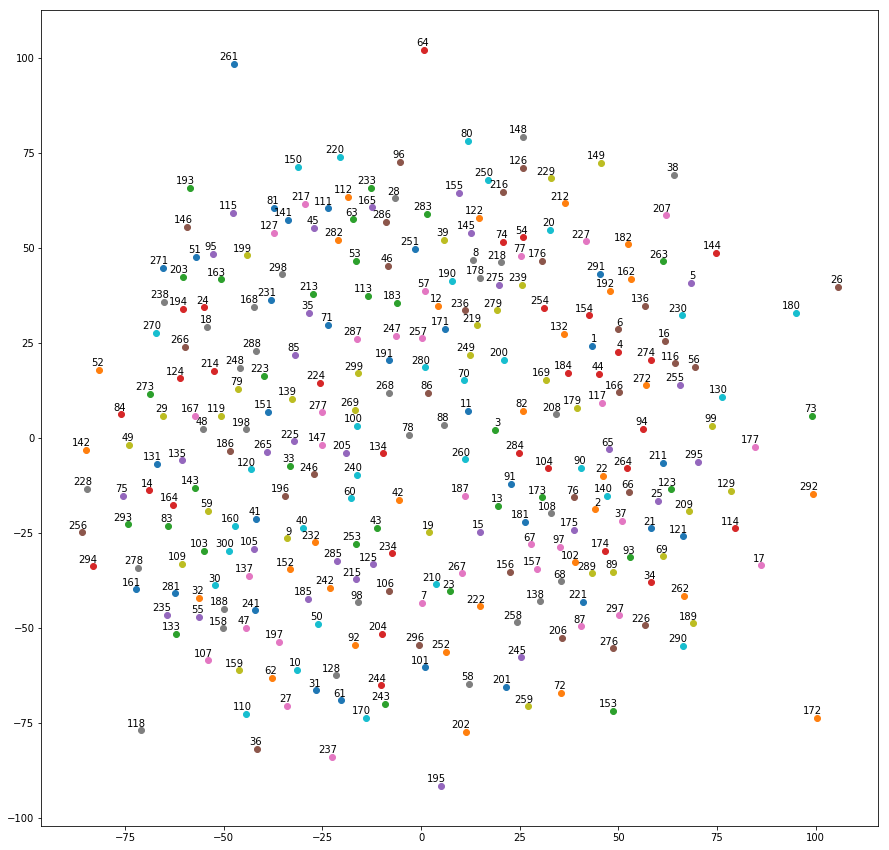

In [12]:
num_points = 300

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

articles_ids = [i for i in range(1, num_points+1)]
plot(two_d_embeddings, articles_ids)

In [20]:
print('Articles close to each other:')
print(reverse_dictionary[116])
print(reverse_dictionary[56])
print('\nArticles close to each other:')
print(reverse_dictionary[188])
print(reverse_dictionary[158])
print('\nArticles close to each other:')
print(reverse_dictionary[51])
print(reverse_dictionary[95])

Articles close to each other:
/articles/2017/12/04/fraiberga
/articles/2017/12/04/sputnik

Articles close to each other:
/articles/2018/01/06/voyna
/articles/2018/01/07/oscorbletsy

Articles close to each other:
/articles/2017/12/13/opg
/articles/2017/12/14/vvz


### Results and conclusion

Dependencies learned by neural network revealed very wise and simple behavioral pattern of online newspaper users. 

**Users tend to read chronologically close articles**. Thus, similarity defined by embeddings does not convey information on topic (genre), author or popularity of an article as it is the case for embeddings trained on e.g. movies recommendation task.

That makes sense as users generally read articles filling in time gaps. They visit easily accessable html links - either via index pages or _read also_ blocks.